In [1]:
!pip install -q efficientnet_pytorch

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from efficientnet_pytorch import EfficientNet
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue, RandomGamma, OneOf, Resize,
    ToFloat, ShiftScaleRotate, GridDistortion, RandomRotate90,
    RGBShift, Blur, MotionBlur, MedianBlur, GaussNoise, CoarseDropout,
     GaussNoise, OpticalDistortion, RandomSizedCrop, VerticalFlip
)
import os
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob
import torchvision
from torch.utils.data import Dataset
import time
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm as tqdm_short
# from tqdm import tqdm
from sklearn import metrics
import cv2
import gc
import torch.nn.functional as F
import seaborn as sns
from sklearn import metrics

## preprocessing

In [3]:
train_df = pd.read_csv('/kaggle/input/ml-dataframe/train.csv').iloc[:,1:]
val_df = pd.read_csv('/kaggle/input/ml-dataframe/valid.csv').iloc[:,1:]

In [4]:
# sampled_train = train_df.groupby('Label').apply(lambda x: x.sample(20))
# sampled_test = train_df.groupby('Label').apply(lambda x: x.sample(5))

# # Reset index to ungroup the DataFrame
# train_df = sampled_train.reset_index(drop=True)
# val_df = sampled_test.reset_index(drop=True)

                                           ImageFileName  Label
9772   /kaggle/input/ml-dataset/dataset/training/jmip...      1
10962  /kaggle/input/ml-dataset/dataset/training/jmip...      1
6636   /kaggle/input/ml-dataset/dataset/training/cove...      0
17363  /kaggle/input/ml-dataset/dataset/validation/jm...      1
30961  /kaggle/input/ml-dataset/dataset/training/uerd...      3
10977  /kaggle/input/ml-dataset/dataset/training/jmip...      1
28609  /kaggle/input/ml-dataset/dataset/training/uerd...      3
6646   /kaggle/input/ml-dataset/dataset/training/cove...      0
6349   /kaggle/input/ml-dataset/dataset/training/cove...      0
25352  /kaggle/input/ml-dataset/dataset/validation/ju...      2


Text(0.5, 1.0, 'Distribution of Classes')

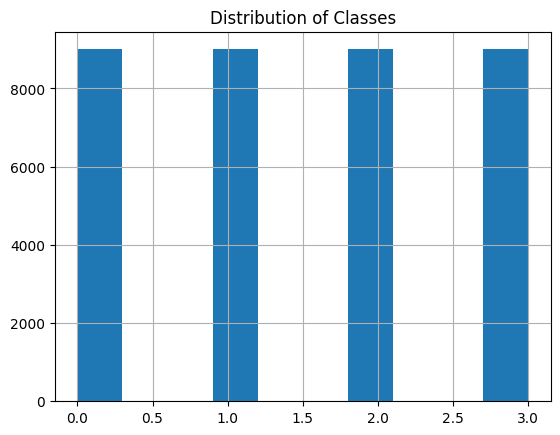

In [5]:
class_names = ['cover','jmipod','juniward','uerd']
class_labels = { name: i for i, name in enumerate(class_names)}
print(train_df.sample(10))
train_df.Label.hist()
plt.title('Distribution of Classes')

# dataset

In [6]:
class Alaska2Dataset(Dataset):

    def __init__(self, df, augmentations=None):

        self.data = df
        self.augment = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fn, label = self.data.loc[idx]
        im = cv2.imread(fn)[:, :, ::-1]
        if self.augment:
            # Apply transformations
            im = self.augment(image=im)
        return im, label


img_size = 512
AUGMENTATIONS_TRAIN = Compose([
    ToFloat(max_value=255),
    ToTensorV2()
], p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=255),
    ToTensorV2()
], p=1)

In [7]:
batch_size = 8
num_workers = 4

train_dataset = Alaska2Dataset(train_df, augmentations=AUGMENTATIONS_TRAIN)
valid_dataset = Alaska2Dataset(val_df, augmentations=AUGMENTATIONS_TEST) #for faster validation sample

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size*2,
                                           num_workers=num_workers,
                                           shuffle=False)

# model

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # 1280 is the number of neurons in last layer. is diff for diff. architecture
        self.dense_output = nn.Linear(1280, num_classes)

    def forward(self, x):
        feat = self.model.extract_features(x)
        feat = F.avg_pool2d(feat, feat.size()[2:]).reshape(-1, 1280)
        return self.dense_output(feat)

In [9]:
def alaska_weighted_auc(y_true, y_valid):
    if np.sum(y_true) == 0:
        # Handle case where there are no positive samples
        return 0.0
    
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        if mask.sum() == 0:
            continue

        x_padding = np.linspace(fpr[mask][-1], 1, 100)
        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        competition_metric += submetric
        
    return competition_metric / normalization


In [10]:
device = 'cuda'
model = Net(num_classes=len(class_labels)).to(device)
# model.load_state_dict(torch.load('/kaggle/working/epoch_1_val_loss_11.2_auc_0.0571.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 157MB/s]


Loaded pretrained weights for efficientnet-b0


In [11]:
num_epochs = 15
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    model.train()
    running_loss = 0
    tk0 = tqdm_notebook(train_loader, total=int(len(train_loader)))
    for im, labels in tk0:
        inputs = im["image"].to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tk0.set_postfix(loss=(loss.item()))

    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    print('Training Loss: {:.8f}'.format(epoch_loss))

    tk1 = tqdm_short(valid_loader, total=int(len(valid_loader)))
    model.eval()
    running_loss = 0
    y, preds = [], []
    with torch.no_grad():
        for (im, labels) in tk1:
            inputs = im["image"].to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            y.extend(labels.cpu().numpy().astype(int))
            preds.extend(F.softmax(outputs, 1).cpu().numpy())
            running_loss += loss.item()
            tk1.set_postfix(loss=(loss.item()))

        epoch_loss = running_loss / (len(valid_loader)/batch_size)
        val_loss.append(epoch_loss)
        preds = np.array(preds)
        # convert multiclass labels to binary class
        y = np.array(y)
        labels = preds.argmax(1)
        acc_all = 'accuracy for class '
        for class_label in np.unique(y):
            idx = y == class_label
            acc = (labels[idx] == y[idx]).astype(float).mean()*100
            acc_all += f"{class_names[class_label]} = {acc}, "
        
        acc = (labels == y).mean()*100
        new_preds = np.zeros((len(preds),))
        temp = preds[labels != 0, 1:]
        new_preds[labels != 0] = temp.sum(1)
        new_preds[labels == 0] = 1 - preds[labels == 0, 0]
        y = np.array(y)
        y[y != 0] = 1
        auc_score = alaska_weighted_auc(y, new_preds)
        print(acc_all)
        print(
            f'Val Loss: {epoch_loss:.3}, Weighted AUC:{auc_score:.3}, Acc: {acc:.3}')

    torch.save(model.state_dict(),
               f"epoch_{epoch}_val_loss_{epoch_loss:.3}_auc_{auc_score:.3}.pth")

Epoch 0/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 11.14088968


100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=1.44]


accuracy for class cover = 19.6, jmipod = 29.299999999999997, juniward = 31.6, uerd = 19.3, 
Val Loss: 11.1, Weighted AUC:0.586, Acc: 24.9
Epoch 1/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 11.12002534


100%|██████████| 250/250 [00:43<00:00,  5.81it/s, loss=1.42]


accuracy for class cover = 19.400000000000002, jmipod = 28.7, juniward = 27.400000000000002, uerd = 26.400000000000002, 
Val Loss: 11.1, Weighted AUC:0.588, Acc: 25.5
Epoch 2/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 11.10678048


100%|██████████| 250/250 [00:43<00:00,  5.81it/s, loss=1.42]

accuracy for class cover = 20.4, jmipod = 26.5, juniward = 27.0, uerd = 31.6, 
Val Loss: 11.1, Weighted AUC:0.591, Acc: 26.4
Epoch 3/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 11.08470640


100%|██████████| 250/250 [00:42<00:00,  5.82it/s, loss=1.42]


accuracy for class cover = 21.5, jmipod = 25.7, juniward = 25.7, uerd = 37.2, 
Val Loss: 11.1, Weighted AUC:0.598, Acc: 27.5
Epoch 4/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 11.03440309


100%|██████████| 250/250 [00:43<00:00,  5.80it/s, loss=1.43]

accuracy for class cover = 21.7, jmipod = 25.1, juniward = 25.900000000000002, uerd = 43.7, 
Val Loss: 11.0, Weighted AUC:0.614, Acc: 29.1
Epoch 5/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.90962000


100%|██████████| 250/250 [00:42<00:00,  5.82it/s, loss=1.45]


accuracy for class cover = 23.799999999999997, jmipod = 31.2, juniward = 24.7, uerd = 43.0, 
Val Loss: 10.8, Weighted AUC:0.629, Acc: 30.7
Epoch 6/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.74830748


100%|██████████| 250/250 [00:42<00:00,  5.83it/s, loss=1.45]

accuracy for class cover = 23.599999999999998, jmipod = 33.7, juniward = 28.4, uerd = 41.6, 
Val Loss: 10.6, Weighted AUC:0.642, Acc: 31.8
Epoch 7/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.60972595


100%|██████████| 250/250 [00:42<00:00,  5.82it/s, loss=1.47]


accuracy for class cover = 25.1, jmipod = 33.0, juniward = 32.1, uerd = 40.8, 
Val Loss: 10.5, Weighted AUC:0.65, Acc: 32.8
Epoch 8/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.53448520


100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=1.49]

accuracy for class cover = 26.6, jmipod = 34.8, juniward = 33.1, uerd = 38.1, 
Val Loss: 10.4, Weighted AUC:0.655, Acc: 33.1
Epoch 9/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.46913363


100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=1.47]


accuracy for class cover = 27.700000000000003, jmipod = 32.0, juniward = 33.5, uerd = 40.8, 
Val Loss: 10.3, Weighted AUC:0.66, Acc: 33.5
Epoch 10/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.43489408


100%|██████████| 250/250 [00:42<00:00,  5.86it/s, loss=1.52]


accuracy for class cover = 28.4, jmipod = 32.2, juniward = 34.4, uerd = 36.4, 
Val Loss: 10.3, Weighted AUC:0.661, Acc: 32.9
Epoch 11/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.39999805


100%|██████████| 250/250 [00:42<00:00,  5.81it/s, loss=1.45]


accuracy for class cover = 28.499999999999996, jmipod = 32.300000000000004, juniward = 31.4, uerd = 42.699999999999996, 
Val Loss: 10.2, Weighted AUC:0.667, Acc: 33.7
Epoch 12/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.37135312


100%|██████████| 250/250 [00:42<00:00,  5.88it/s, loss=1.48]


accuracy for class cover = 28.1, jmipod = 34.4, juniward = 32.300000000000004, uerd = 41.5, 
Val Loss: 10.2, Weighted AUC:0.67, Acc: 34.1
Epoch 13/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.35755086


100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=1.46]

accuracy for class cover = 27.900000000000002, jmipod = 32.4, juniward = 33.800000000000004, uerd = 42.699999999999996, 
Val Loss: 10.2, Weighted AUC:0.672, Acc: 34.2
Epoch 14/14
----------


  0%|          | 0/4500 [00:00<?, ?it/s]

Training Loss: 10.28731671


100%|██████████| 250/250 [00:42<00:00,  5.84it/s, loss=1.44]

accuracy for class cover = 26.0, jmipod = 32.2, juniward = 33.5, uerd = 46.300000000000004, 
Val Loss: 10.1, Weighted AUC:0.675, Acc: 34.5


Text(0.5, 1.0, 'Loss Plot')

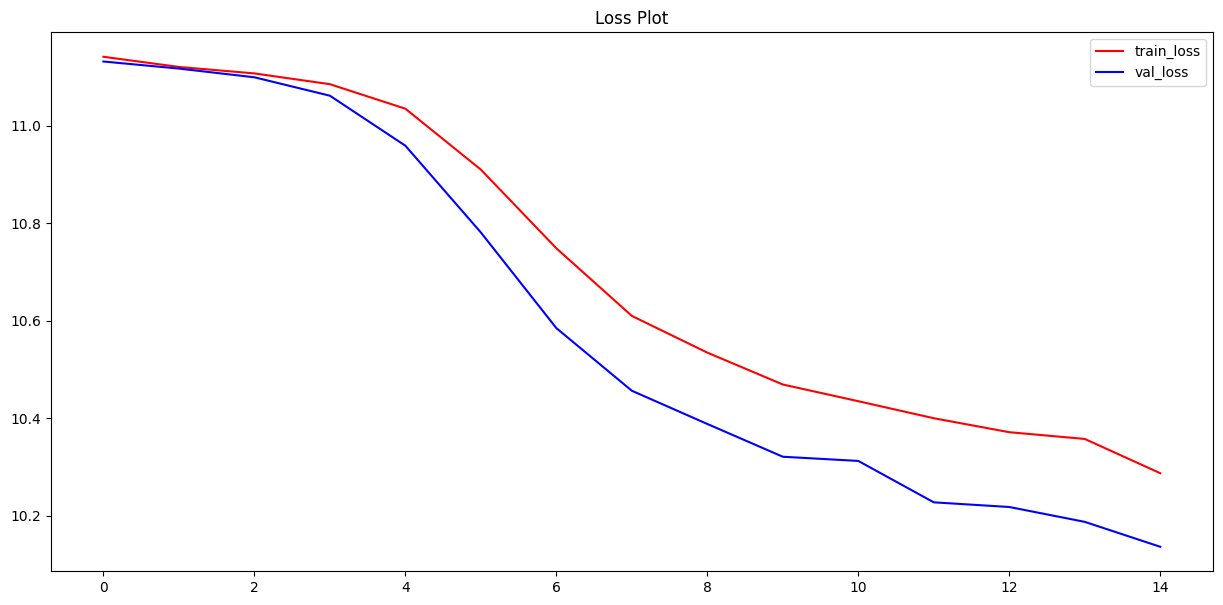

In [12]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, c='r')
plt.plot(val_loss, c='b')
plt.legend(['train_loss', 'val_loss'])
plt.title('Loss Plot')

In [13]:
tk1 = tqdm_short(valid_loader, total=int(len(valid_loader)))
model.eval()
running_loss = 0
y, preds = [], []
with torch.no_grad():
    for (im, labels) in tk1:
        inputs = im["image"].to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        y.extend(labels.cpu().numpy().astype(int))
        preds.extend(F.softmax(outputs, 1).cpu().numpy())
    preds = np.array(preds)

100%|██████████| 250/250 [00:42<00:00,  5.89it/s]


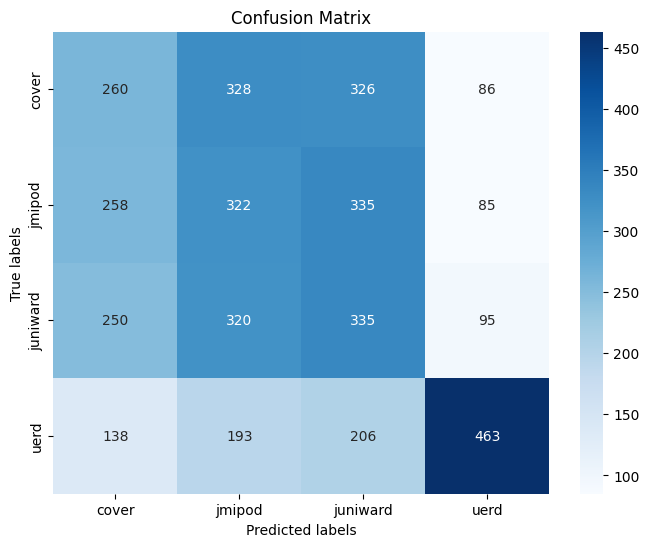

Classification Report:
              precision    recall  f1-score   support

       cover       0.29      0.26      0.27      1000
      jmipod       0.28      0.32      0.30      1000
    juniward       0.28      0.34      0.30      1000
        uerd       0.64      0.46      0.54      1000

    accuracy                           0.34      4000
   macro avg       0.37      0.35      0.35      4000
weighted avg       0.37      0.34      0.35      4000



In [14]:
predicted_labels = preds.argmax(axis=1)

# Define class names based on the mapping dictionary
class_names = {0: 'cover', 1: 'jmipod', 2: 'juniward', 3: 'uerd'}

# Map numerical labels to class names for true labels and predicted labels
y_class_names = np.vectorize(class_names.get)(y)
predicted_class_names = np.vectorize(class_names.get)(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_class_names, predicted_class_names, labels=list(class_names.values()))

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Create classification report
print("Classification Report:")
print(classification_report(y_class_names, predicted_class_names, target_names=list(class_names.values())))
